In [1]:
# Import Matplotlib and associated items
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as pyplot

In [2]:
# Import other Dependencies
import datetime as dt
import numpy as np
import pandas as pd

In [3]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
 # We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

In [9]:
# Designed a query to retrieve the last 12 months of precipitation data using ALL data
all_data = pd.read_sql("SELECT date, prcp AS 'precipitation' \
FROM Measurement WHERE date >= '2016-08-23'", conn)
# Preview the Data
all_data.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


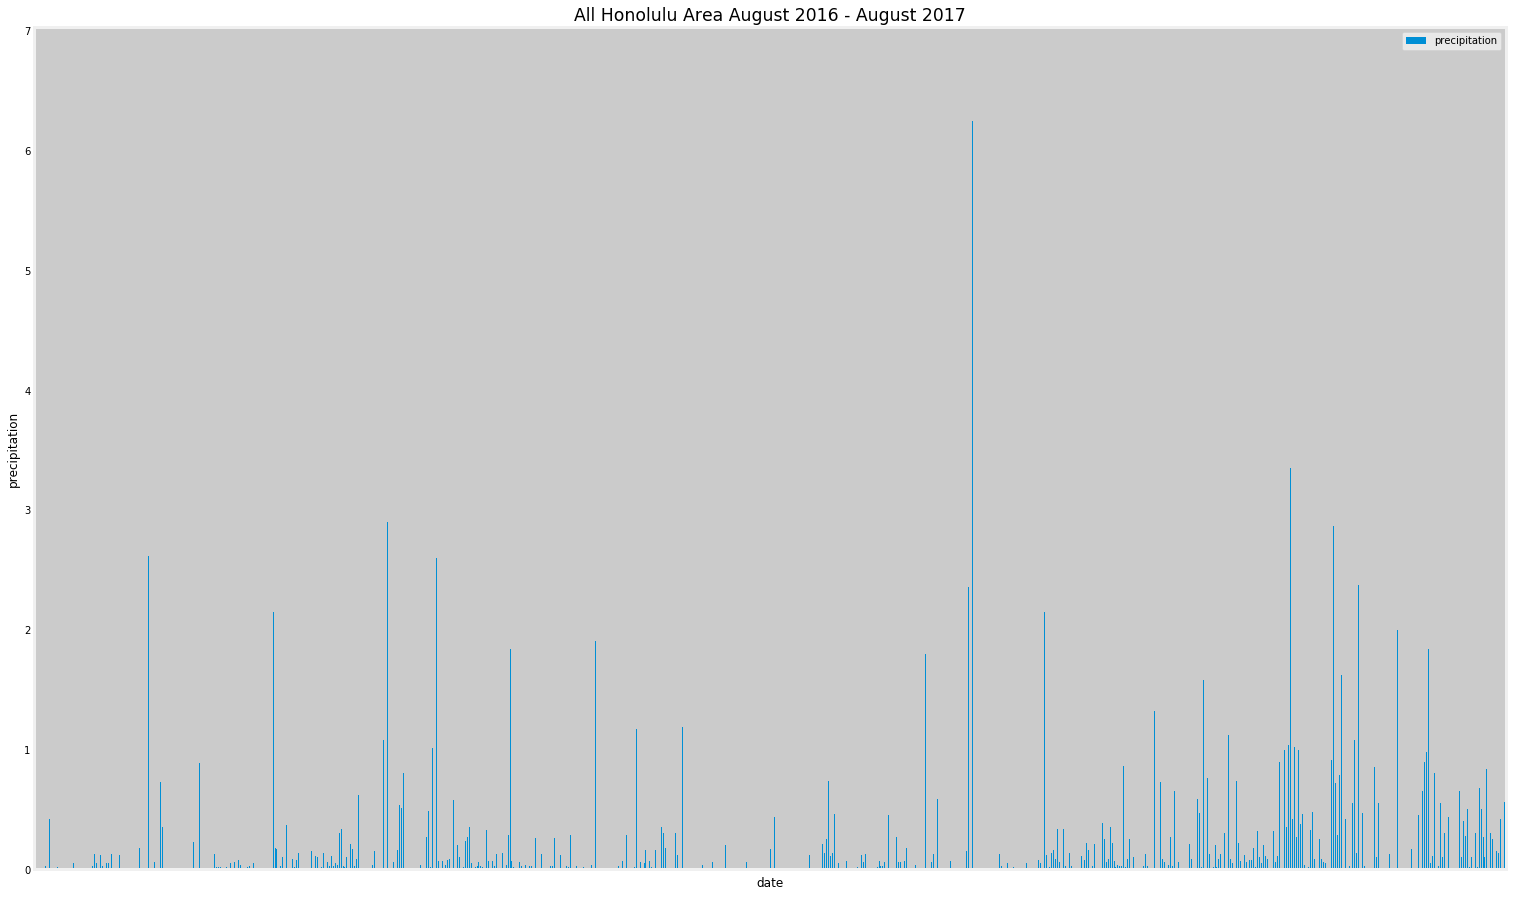

In [11]:
# Plot the data
xlabels = ('')
ax = all_data.plot.bar(x='date', y='precipitation')
ax.set_title("All Honolulu Area August 2016 - August 2017", fontsize='xx-large')
ax.set_ylabel("precipitation")
ax.set_xticklabels(xlabels)
fig = pyplot.gcf()
fig.set_size_inches(23.5, 15.5)

In [12]:
# Summary statistics for all the data
all_data.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Designed a query to show how many stations are available in this dataset?
data_stations = engine.execute("SELECT DISTINCT station FROM Measurement")
count = 0
for station in data_stations:
    count += 1
    print(station)
print("There are", count, "stations available in this dataset.")

('USC00519397',)
('USC00513117',)
('USC00514830',)
('USC00517948',)
('USC00518838',)
('USC00519523',)
('USC00519281',)
('USC00511918',)
('USC00516128',)
There are 9 stations available in this dataset.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
#Using the station id from the previous query('USC00519281' which is Waihee), 
# calculate the lowest temperature recorded, highest temperature recorded, 
# and average temperature of the most active station.
# Calculated based on the last year of data only:

temps_of_most_active_station = pd.read_sql("SELECT MAX(tobs) AS 'maximum_temperature', \
MIN(tobs) AS 'minimum_temperature', \
AVG(tobs) AS 'average_temperature' \
FROM Measurement \
WHERE station = 'USC00519281' AND date >= '2016-08-23'", conn)
temps_of_most_active_station

,maximum_temperature,minimum_temperature,average_temperature
0,83.0,59.0,73.107955


In [17]:
# Choose the station with the highest number of temperature observations, 
# which is Waihee (USC00519281).
# Query the last 12 months of temperature observation data for this station

waihee_temps_last_12_months = pd.read_sql("SELECT date, tobs AS 'Temperature Observations' \
FROM Measurement \
WHERE station = 'USC00519281' AND date >= '2016-08-23'", conn)
waihee_temps_last_12_months.head()

,date,Temperature Observations
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


Text(0.5, 1.05, 'Waihee: August 2016-August 2017')

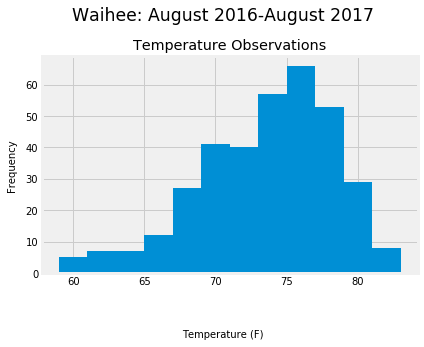

In [18]:
# Plot the results as a histogram using 12 bins and adding a title and x and y labels
fig, axes = pyplot.subplots(sharey=True)
waihee_temps_last_12_months.hist(bins=12, ax=axes)
fig.text(0.5, -0.1, 'Temperature (F)', ha='center')
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical')
pyplot.suptitle('Waihee: August 2016-August 2017', x=0.5, y=1.05, ha='center', fontsize='xx-large')

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# For a trip from May 11 - May 20, using 2017 data
# printing the mininum temperature, the average temperature, and the maximum temperature

print(calc_temps('2017-05-11', '2017-05-20'))

[(68.0, 74.89090909090909, 79.0)]


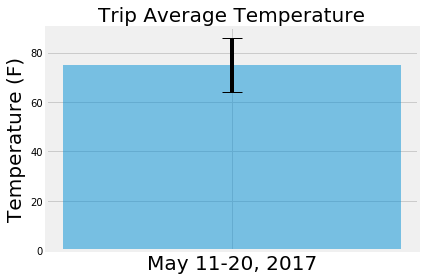

In [21]:
# Plot the results as a bar chart using average temperature for the y value
# and the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min = 68
mean = 74.89
max = 79

x_pos = np.arange(1)
label = ['May 11-20, 2017']

# Build the plot
fig, ax = pyplot.subplots()
ax.bar(x_pos, mean, yerr=max-min, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Temperature (F)', fontsize=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(label, fontsize=20)
ax.set_title('Trip Average Temperature', fontsize=20)
ax.yaxis.grid(True)

# Use tight layout and show the bar graph
pyplot.tight_layout()
pyplot.show()